In [1]:
import requests
import zipfile
import io
import numpy as np


# Function to download the zip file
def download_zip(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)


# Function to read data from 'imu.txt' into arrays for each column
def read_imu_data(zip_path):
    serial_num = []
    timestamps = []
    wx_values = []
    wy_values = []
    wz_values = []
    ax_values = []
    ay_values = []
    az_values = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open('imu.txt') as imu_file:
            next(imu_file)  # Skip the first line
            for line in imu_file:
                line = line.decode('utf-8').strip().split()
                sn, ts, wx, wy, wz, ax, ay, az = map(float, line)
                serial_num.append(sn)
                timestamps.append(ts)
                wx_values.append(wx)
                wy_values.append(wy)
                wz_values.append(wz)
                ax_values.append(ax)
                ay_values.append(ay)
                az_values.append(az)

    imu_data = np.zeros((len(ax_values),7))
    imu_data[:, 0] = timestamps
    imu_data[:, 1] = wx_values
    imu_data[:, 2] = wy_values
    imu_data[:, 3] = wz_values
    imu_data[:, 4] = ax_values
    imu_data[:, 5] = ay_values
    imu_data[:, 6] = az_values
    # Convert lists to numpy arrays
    serial_num = np.array(serial_num)
    timestamps = np.array(timestamps)
    wx_values = np.array(wx_values)
    wy_values = np.array(wy_values)
    wz_values = np.array(wz_values)
    ax_values = np.array(ax_values)
    ay_values = np.array(ay_values)
    az_values = np.array(az_values)
    print(imu_data)
    return serial_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values, imu_data


In [2]:

## URL of the zip file
#zip_url = 'http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/indoor_forward_9_davis_with_gt.zip'
zip_url = 'http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/indoor_forward_3_davis_with_gt.zip'
## Path to save the downloaded zip file
zip_save_path = 'indoor_forward_3_davis_with_gt.zip'
zip_save = "C:\FinalProject\indoor_forward_3_davis_with_gt.zip"
## Download the zip file
# download_zip(zip_url, zip_save_path)

## Read data from the 'imu.txt' file into arrays for each column
samp_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values, imu_data = read_imu_data(zip_save)


[[ 1.54082024e+09 -6.49811264e-02 -5.32632218e-03 ...  6.89765625e-01
  -9.81958008e+00  1.00590820e+00]
 [ 1.54082024e+09 -6.49811264e-02 -5.32632218e-03 ...  6.94555664e-01
  -9.81479004e+00  1.01069824e+00]
 [ 1.54082024e+09 -6.39158620e-02 -4.26105748e-03 ...  7.08925781e-01
  -9.81479004e+00  1.01069824e+00]
 ...
 [ 1.54082033e+09 -9.69390554e-02  5.32632218e-03 ...  1.12086914e+00
  -9.80520996e+00  9.81958008e-01]
 [ 1.54082033e+09 -9.90695842e-02  4.26105748e-03 ...  1.07775879e+00
  -9.81958008e+00  1.05380859e+00]
 [ 1.54082033e+09 -9.80043198e-02  5.32632218e-03 ...  1.05859863e+00
  -9.84832031e+00  1.14481934e+00]]


In [14]:
### trying by libraries
from ahrs.filters import Mahony
import numpy as np

timestamp = imu_data[25000:800000:,  0]
gyro_data = imu_data[25000:80000:, 1:4]
acc_data  = imu_data[25000:80000:, 4:7]
time_step = timestamp[10]-timestamp[9]

# num_samples = 60000-16000


In [15]:

num_samples = len(timestamp)
print(num_samples)
print("hello")
print(timestamp)
# print(gyro_data)
# print(acc_data)
print(time_step)

64328
hello
[1.54082026e+09 1.54082026e+09 1.54082026e+09 ... 1.54082033e+09
 1.54082033e+09 1.54082033e+09]
0.0010008811950683594


In [16]:

orientation = Mahony()
Q = np.tile([1., 0., 0., 0.], (len(gyro_data), 1)) # Allocate for quaternions
for t in range(1, len(gyro_data)):
    Q[t] = orientation.updateIMU(Q[t-1], gyr=gyro_data[t], acc=acc_data[t])    


In [17]:
print(Q)

def quaternion_to_euler(q):
    """
    Convert quaternion to Euler angles (roll, pitch, yaw).
    q: array-like, shape (4,) quaternion (w, x, y, z)
    Returns: array-like, shape (3,) Euler angles (roll, pitch, yaw)
    """
    r = R.from_quat([q[1], q[2], q[3], q[0]])  # scipy uses (x, y, z, w) order
    return r.as_euler('xyz', degrees=True)  

import numpy as np

def compute_3d_coordinates(quaternions):
    positions = np.zeros((len(quaternions), 3))  # Initialize positions array
    for i, q in enumerate(quaternions):
        euler = quaternion_to_euler(q)
        if i > 0:
            positions[i] = positions[i-1] + np.array([np.cos(euler[1]) * np.cos(euler[2]),
                                                      np.cos(euler[1]) * np.sin(euler[2]),
                                                      np.sin(euler[1])])
    return positions

[[ 9.99977010e-01 -6.76334316e-03 -4.77083736e-04 -9.58715951e-05]
 [ 9.99908166e-01 -1.35167051e-02 -9.59975915e-04 -1.91791191e-04]
 [ 9.99793680e-01 -2.02587814e-02 -1.44873573e-03 -2.82463189e-04]
 ...
 [-5.06196618e-01  6.94671004e-01 -2.65796421e-01  4.36519693e-01]
 [-5.11415673e-01  6.97626243e-01 -2.57753346e-01  4.30505339e-01]
 [-5.11415673e-01  6.97626243e-01 -2.57753346e-01  4.30505339e-01]]


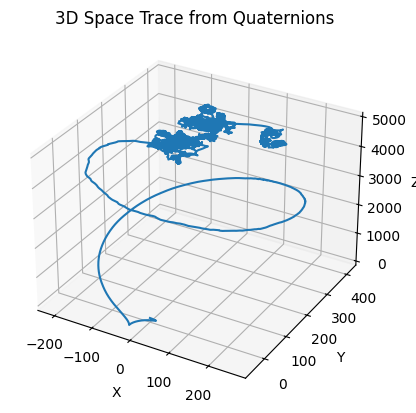

In [18]:
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
plt.ion()

# Example quaternions (replace with your data)
# quaternions = np.tile([1., 0., 0., 0.], (100, 1))  # Dummy data for testing

# Compute 3D coordinates
positions = compute_3d_coordinates(Q)

# Plot the 3D trace
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Space Trace from Quaternions')
plt.show()


In [ ]:
# until here for now

In [19]:

from dataclasses import dataclass
from matplotlib import animation
from scipy.interpolate import interp1d

import imufusion
import matplotlib.pyplot as pyplot
import numpy

# %matplotlib qt

# Import sensor data ("short_walk.csv" or "long_walk.csv")
# data = numpy.genfromtxt("short_walk.csv", delimiter=",", skip_header=1)
# print(data, type(data), len(data))
sample_rate = 400  # 400 Hz
print(imu_data)
##timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values
# timestamp = data[:, 0]
# gyroscope = data[:, 1:4]
# accelerometer = data[:, 4:7]
timestamp = (imu_data[30000:60000:10, 1])
gyroscope = imu_data[30000:60000:10, 2:4]
accelerometer = imu_data[30000:60000:10, 5:7]
print(accelerometer[:, 2])
accelerometer[:, 2] = accelerometer[:, 2] 
print(accelerometer[:, 2])
print("here")
# print(accelerometer[2000:2100, 2])
# Plot sensor data
figure, axes = pyplot.subplots(nrows=6, sharex=True, gridspec_kw={"height_ratios": [6, 6, 6, 2, 1, 1]})

figure.suptitle("Sensors data, Euler angles, and AHRS internal states")

axes[0].plot(timestamp, gyroscope[:, 0], "tab:red", label="Gyroscope X")
axes[0].plot(timestamp, gyroscope[:, 1], "tab:green", label="Gyroscope Y")
axes[0].plot(timestamp, gyroscope[:, 2], "tab:blue", label="Gyroscope Z")
axes[0].set_ylabel("Degrees/s")
axes[0].grid()
axes[0].legend()

axes[1].plot(timestamp, accelerometer[:, 0], "tab:red", label="Accelerometer X")
axes[1].plot(timestamp, accelerometer[:, 1], "tab:green", label="Accelerometer Y")
axes[1].plot(timestamp, accelerometer[:, 2], "tab:blue", label="Accelerometer Z")
axes[1].set_ylabel("g")
axes[1].grid()
axes[1].legend()

# Instantiate AHRS algorithms
offset = imufusion.Offset(sample_rate)
ahrs = imufusion.Ahrs()

ahrs.settings = imufusion.Settings(imufusion.CONVENTION_NWU,
                                   0.5,  # gain
                                   2000,  # gyroscope range
                                   10,  # acceleration rejection
                                   0,  # magnetic rejection
                                   5 * sample_rate)  # rejection timeout = 5 seconds

# Process sensor data
delta_time = numpy.diff(timestamp, prepend=timestamp[0])

euler = numpy.empty((len(timestamp), 3))
internal_states = numpy.empty((len(timestamp), 3))
acceleration = numpy.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    gyroscope[index] = offset.update(gyroscope[index])

    ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], delta_time[index])

    euler[index] = ahrs.quaternion.to_euler()

    ahrs_internal_states = ahrs.internal_states
    internal_states[index] = numpy.array([ahrs_internal_states.acceleration_error,
                                          ahrs_internal_states.accelerometer_ignored,
                                          ahrs_internal_states.acceleration_recovery_trigger])

    acceleration[index] = 9.81 * ahrs.earth_acceleration  # convert g to m/s/s
    # acceleration[index] =  ahrs.earth_acceleration  # convert g to m/s/s

# Plot Euler angles
axes[2].plot(timestamp, euler[:, 0], "tab:red", label="Roll")
axes[2].plot(timestamp, euler[:, 1], "tab:green", label="Pitch")
axes[2].plot(timestamp, euler[:, 2], "tab:blue", label="Yaw")
axes[2].set_ylabel("Degrees")
axes[2].grid()
axes[2].legend()

# Plot internal states
axes[3].plot(timestamp, internal_states[:, 0], "tab:olive", label="Acceleration error")
axes[3].set_ylabel("Degrees")
axes[3].grid()
axes[3].legend()

axes[4].plot(timestamp, internal_states[:, 1], "tab:cyan", label="Accelerometer ignored")
pyplot.sca(axes[4])
pyplot.yticks([0, 1], ["False", "True"])
axes[4].grid()
axes[4].legend()

axes[5].plot(timestamp, internal_states[:, 2], "tab:orange", label="Acceleration recovery trigger")
axes[5].set_xlabel("Seconds")
axes[5].grid()
axes[5].legend()

# Plot acceleration
_, axes = pyplot.subplots(nrows=4, sharex=True, gridspec_kw={"height_ratios": [6, 1, 6, 6]})

axes[0].plot(timestamp, acceleration[:, 0], "tab:red", label="X")
axes[0].plot(timestamp, acceleration[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp, acceleration[:, 2], "tab:blue", label="Z")
axes[0].set_title("Acceleration")
axes[0].set_ylabel("m/s/s")
axes[0].grid()
axes[0].legend()

# Identify moving periods
is_moving = numpy.empty(len(timestamp))

for index in range(len(timestamp)):
    is_moving[index] = numpy.sqrt(acceleration[index].dot(acceleration[index])) > 3  # threshold = 3 m/s/s

margin = int(0.1 * sample_rate)  # 100 ms

for index in range(len(timestamp) - margin):
    is_moving[index] = any(is_moving[index:(index + margin)])  # add leading margin

for index in range(len(timestamp) - 1, margin, -1):
    is_moving[index] = any(is_moving[(index - margin):index])  # add trailing margin

# Plot moving periods
axes[1].plot(timestamp, is_moving, "tab:cyan", label="Is moving")
pyplot.sca(axes[1])
pyplot.yticks([0, 1], ["False", "True"])
axes[1].grid()
axes[1].legend()

# Calculate velocity (includes integral drift)
velocity = numpy.zeros((len(timestamp), 3))

for index in range(len(timestamp)):
    if is_moving[index]:  # only integrate if moving
        velocity[index] = velocity[index - 1] + delta_time[index] * acceleration[index]

# Find start and stop indices of each moving period
is_moving_diff = numpy.diff(is_moving, append=is_moving[-1])


@dataclass
class IsMovingPeriod:
    start_index: int = -1
    stop_index: int = -1


is_moving_periods = []
is_moving_period = IsMovingPeriod()

for index in range(len(timestamp)):
    if is_moving_period.start_index == -1:
        if is_moving_diff[index] == 1:
            is_moving_period.start_index = index

    elif is_moving_period.stop_index == -1:
        if is_moving_diff[index] == -1:
            is_moving_period.stop_index = index
            is_moving_periods.append(is_moving_period)
            is_moving_period = IsMovingPeriod()

# Remove integral drift from velocity
velocity_drift = numpy.zeros((len(timestamp), 3))

for is_moving_period in is_moving_periods:
    start_index = is_moving_period.start_index
    stop_index = is_moving_period.stop_index

    t = [timestamp[start_index], timestamp[stop_index]]
    x = [velocity[start_index, 0], velocity[stop_index, 0]]
    y = [velocity[start_index, 1], velocity[stop_index, 1]]
    z = [velocity[start_index, 2], velocity[stop_index, 2]]

    t_new = timestamp[start_index:(stop_index + 1)]

    velocity_drift[start_index:(stop_index + 1), 0] = interp1d(t, x)(t_new)
    velocity_drift[start_index:(stop_index + 1), 1] = interp1d(t, y)(t_new)
    velocity_drift[start_index:(stop_index + 1), 2] = interp1d(t, z)(t_new)

velocity = velocity - velocity_drift

# Plot velocity
axes[2].plot(timestamp, velocity[:, 0], "tab:red", label="X")
axes[2].plot(timestamp, velocity[:, 1], "tab:green", label="Y")
axes[2].plot(timestamp, velocity[:, 2], "tab:blue", label="Z")
axes[2].set_title("Velocity")
axes[2].set_ylabel("m/s")
axes[2].grid()
axes[2].legend()

# Calculate position
position = numpy.zeros((len(timestamp), 3))

for index in range(len(timestamp)):
    position[index] = position[index - 1] + delta_time[index] * velocity[index]

# Plot position
axes[3].plot(timestamp, position[:, 0], "tab:red", label="X")
axes[3].plot(timestamp, position[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp, position[:, 2], "tab:blue", label="Z")
axes[3].set_title("Position")
axes[3].set_xlabel("Seconds")
axes[3].set_ylabel("m")
axes[3].grid()
axes[3].legend()

# Print error as distance between start and final positions
print("Error: " + "{:.3f}".format(numpy.sqrt(position[-1].dot(position[-1]))) + " m")

# Create 3D animation (takes a long time, set to False to skip)
if True:
    figure = pyplot.figure(figsize=(10, 10))

    axes = pyplot.axes(projection="3d")
    axes.set_xlabel("m")
    axes.set_ylabel("m")
    axes.set_zlabel("m")

    x = []
    y = []
    z = []

    scatter = axes.scatter(x, y, z)

    fps = 30
    samples_per_frame = int(sample_rate / fps)

    def update(frame):
        index = frame * samples_per_frame

        axes.set_title("{:.3f}".format(timestamp[index]) + " s")

        x.append(position[index, 0])
        y.append(position[index, 1])
        z.append(position[index, 2])
        # z = np.array(z_old) - 9.81

        scatter._offsets3d = (x, y, z)
        # scatter._offsets3d = (x, y)

        if (min(x) != max(x)) and (min(y) != max(y)) and (min(z) != max(z)):
            axes.set_xlim3d(min(x), max(x))
            axes.set_ylim3d(min(y), max(y))
            axes.set_zlim3d(min(z), max(z))

            axes.set_box_aspect((numpy.ptp(x), numpy.ptp(y), numpy.ptp(z)))

        return scatter

    anim = animation.FuncAnimation(figure, update,
                                   frames=int(len(timestamp) / samples_per_frame),
                                   interval=1000 / fps,
                                   repeat=False)

    anim.save("animation.gif", writer=animation.PillowWriter(fps))

pyplot.show()

[[ 1.54082024e+09 -6.49811264e-02 -5.32632218e-03 ...  6.89765625e-01
  -9.81958008e+00  1.00590820e+00]
 [ 1.54082024e+09 -6.49811264e-02 -5.32632218e-03 ...  6.94555664e-01
  -9.81479004e+00  1.01069824e+00]
 [ 1.54082024e+09 -6.39158620e-02 -4.26105748e-03 ...  7.08925781e-01
  -9.81479004e+00  1.01069824e+00]
 ...
 [ 1.54082033e+09 -9.69390554e-02  5.32632218e-03 ...  1.12086914e+00
  -9.80520996e+00  9.81958008e-01]
 [ 1.54082033e+09 -9.90695842e-02  4.26105748e-03 ...  1.07775879e+00
  -9.81958008e+00  1.05380859e+00]
 [ 1.54082033e+09 -9.80043198e-02  5.32632218e-03 ...  1.05859863e+00
  -9.84832031e+00  1.14481934e+00]]


IndexError: index 2 is out of bounds for axis 1 with size 2

In [9]:
import requests
import zipfile
import io
import numpy as np


# Function to download the zip file
def download_zip(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as f:
        f.write(response.content)


# Function to read data from 'imu.txt' into arrays for each column
def read_imu_data(zip_path):
    serial_num = []
    timestamps = []
    wx_values = []
    wy_values = []
    wz_values = []
    ax_values = []
    ay_values = []
    az_values = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        with zip_ref.open('imu.txt') as imu_file:
            next(imu_file)  # Skip the first line
            for line in imu_file:
                line = line.decode('utf-8').strip().split()
                sn, ts, wx, wy, wz, ax, ay, az = map(float, line)
                serial_num.append(sn)
                timestamps.append(ts)
                wx_values.append(wx)
                wy_values.append(wy)
                wz_values.append(wz)
                ax_values.append(ax)
                ay_values.append(ay)
                az_values.append(az)

    # Convert lists to numpy arrays
    serial_num = np.array(serial_num)
    timestamps = np.array(timestamps)
    wx_values = np.array(wx_values)
    wy_values = np.array(wy_values)
    wz_values = np.array(wz_values)
    ax_values = np.array(ax_values)
    ay_values = np.array(ay_values)
    az_values = np.array(az_values)

    return serial_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values
    
    # URL of the zip file
# zip_url = 'http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/indoor_forward_9_davis_with_gt.zip'
zip_url = 'http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/indoor_forward_3_davis_with_gt.zip'

# Path to save the downloaded zip file
zip_save_path = 'indoor_forward_3_davis_with_gt.zip'

# Download the zip file
download_zip(zip_url, zip_save_path)

# Read data from the 'imu.txt' file into arrays for each column
samp_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values = read_imu_data(zip_save_path)

gyro is [array([0.68976563, 0.69455566, 0.70892578, ..., 1.12086914, 1.07775879,
       1.05859863]), array([-9.81958008, -9.81479004, -9.81479004, ..., -9.80520996,
       -9.81958008, -9.84832031]), array([1.0059082 , 1.01069824, 1.01069824, ..., 0.98195801, 1.05380859,
       1.14481934])] <class 'list'> <class 'numpy.ndarray'> 3


TypeError: list indices must be integers or slices, not tuple

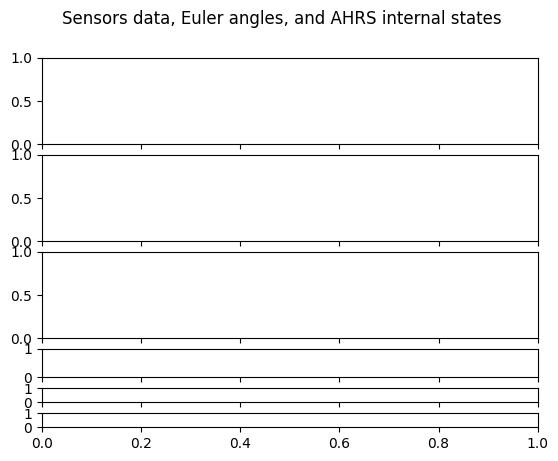

In [10]:

































from dataclasses import dataclass
from matplotlib import animation
from scipy import constants
from scipy.interpolate import interp1d

import imufusion
import matplotlib.pyplot as pyplot
import numpy


# Import sensor data ("short_walk.csv" or "long_walk.csv")
# data = numpy.genfromtxt("short_walk.csv", delimiter=",", skip_header=1)
# timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values
# timestamp = data[:, 0]
# gyroscope = data[:, 1:4]
# accelerometer = data[:, 4:7]
# print(data)
sample_rate = 400  # 400 Hz

timestamp = timestamps
gyroscope = [ax_values, ay_values, az_values]
accelerometer = [wx_values, wy_values, wz_values]

print("gyro is", gyroscope, type(gyroscope), type(gyroscope[0]), len(gyroscope))
# Plot sensor data
figure, axes = pyplot.subplots(nrows=6, sharex=True, gridspec_kw={"height_ratios": [6, 6, 6, 2, 1, 1]})

figure.suptitle("Sensors data, Euler angles, and AHRS internal states")

axes[0].plot(timestamp, gyroscope[:, 0], "tab:red", label="Gyroscope X")
axes[0].plot(timestamp, gyroscope[:, 1], "tab:green", label="Gyroscope Y")
axes[0].plot(timestamp, gyroscope[:, 2], "tab:blue", label="Gyroscope Z")
axes[0].set_ylabel("Degrees/s")
axes[0].grid()
axes[0].legend()

axes[1].plot(timestamp, accelerometer[:, 0], "tab:red", label="Accelerometer X")
axes[1].plot(timestamp, accelerometer[:, 1], "tab:green", label="Accelerometer Y")
axes[1].plot(timestamp, accelerometer[:, 2], "tab:blue", label="Accelerometer Z")
axes[1].set_ylabel("g")
axes[1].grid()
axes[1].legend()

# Instantiate AHRS algorithms
offset = imufusion.Offset(sample_rate)
ahrs = imufusion.Ahrs()

ahrs.settings = imufusion.Settings(imufusion.CONVENTION_NWU,
                                   0.5,  # gain
                                   2000,  # gyroscope range
                                   10,  # acceleration rejection
                                   0,  # magnetic rejection
                                   5 * sample_rate)  # rejection timeout = 5 seconds

# Process sensor data
delta_time = numpy.diff(timestamp, prepend=timestamp[0])

euler = numpy.empty((len(timestamp), 3))
internal_states = numpy.empty((len(timestamp), 3))
acceleration = numpy.empty((len(timestamp), 3))

for index in range(len(timestamp)):
    gyroscope[index] = offset.update(gyroscope[index])

    ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], delta_time[index])

    euler[index] = ahrs.quaternion.to_euler()

    ahrs_internal_states = ahrs.internal_states
    internal_states[index] = numpy.array([ahrs_internal_states.acceleration_error,
                                          ahrs_internal_states.accelerometer_ignored,
                                          ahrs_internal_states.acceleration_recovery_trigger])

    acceleration[index] = 9.81 * ahrs.earth_acceleration  # convert g to m/s/s

# Plot Euler angles
axes[2].plot(timestamp, euler[:, 0], "tab:red", label="Roll")
axes[2].plot(timestamp, euler[:, 1], "tab:green", label="Pitch")
axes[2].plot(timestamp, euler[:, 2], "tab:blue", label="Yaw")
axes[2].set_ylabel("Degrees")
axes[2].grid()
axes[2].legend()

# Plot internal states
axes[3].plot(timestamp, internal_states[:, 0], "tab:olive", label="Acceleration error")
axes[3].set_ylabel("Degrees")
axes[3].grid()
axes[3].legend()

axes[4].plot(timestamp, internal_states[:, 1], "tab:cyan", label="Accelerometer ignored")
pyplot.sca(axes[4])
pyplot.yticks([0, 1], ["False", "True"])
axes[4].grid()
axes[4].legend()

axes[5].plot(timestamp, internal_states[:, 2], "tab:orange", label="Acceleration recovery trigger")
axes[5].set_xlabel("Seconds")
axes[5].grid()
axes[5].legend()

# Plot acceleration
_, axes = pyplot.subplots(nrows=4, sharex=True, gridspec_kw={"height_ratios": [6, 1, 6, 6]})

axes[0].plot(timestamp, acceleration[:, 0], "tab:red", label="X")
axes[0].plot(timestamp, acceleration[:, 1], "tab:green", label="Y")
axes[0].plot(timestamp, acceleration[:, 2], "tab:blue", label="Z")
axes[0].set_title("Acceleration")
axes[0].set_ylabel("m/s/s")
axes[0].grid()
axes[0].legend()

# Identify moving periods
is_moving = numpy.empty(len(timestamp))

for index in range(len(timestamp)):
    is_moving[index] = numpy.sqrt(acceleration[index].dot(acceleration[index])) > 3  # threshold = 3 m/s/s

margin = int(0.1 * sample_rate)  # 100 ms

for index in range(len(timestamp) - margin):
    is_moving[index] = any(is_moving[index:(index + margin)])  # add leading margin

for index in range(len(timestamp) - 1, margin, -1):
    is_moving[index] = any(is_moving[(index - margin):index])  # add trailing margin

# Plot moving periods
axes[1].plot(timestamp, is_moving, "tab:cyan", label="Is moving")
pyplot.sca(axes[1])
pyplot.yticks([0, 1], ["False", "True"])
axes[1].grid()
axes[1].legend()

# Calculate velocity (includes integral drift)
velocity = numpy.zeros((len(timestamp), 3))

for index in range(len(timestamp)):
    if is_moving[index]:  # only integrate if moving
        velocity[index] = velocity[index - 1] + delta_time[index] * acceleration[index]

# Find start and stop indices of each moving period
is_moving_diff = numpy.diff(is_moving, append=is_moving[-1])


@dataclass
class IsMovingPeriod:
    start_index: int = -1
    stop_index: int = -1


is_moving_periods = []
is_moving_period = IsMovingPeriod()

for index in range(len(timestamp)):
    if is_moving_period.start_index == -1:
        if is_moving_diff[index] == 1:
            is_moving_period.start_index = index

    elif is_moving_period.stop_index == -1:
        if is_moving_diff[index] == -1:
            is_moving_period.stop_index = index
            is_moving_periods.append(is_moving_period)
            is_moving_period = IsMovingPeriod()

# Remove integral drift from velocity
velocity_drift = numpy.zeros((len(timestamp), 3))

for is_moving_period in is_moving_periods:
    start_index = is_moving_period.start_index
    stop_index = is_moving_period.stop_index

    t = [timestamp[start_index], timestamp[stop_index]]
    x = [velocity[start_index, 0], velocity[stop_index, 0]]
    y = [velocity[start_index, 1], velocity[stop_index, 1]]
    z = [velocity[start_index, 2], velocity[stop_index, 2]]

    t_new = timestamp[start_index:(stop_index + 1)]

    velocity_drift[start_index:(stop_index + 1), 0] = interp1d(t, x)(t_new)
    velocity_drift[start_index:(stop_index + 1), 1] = interp1d(t, y)(t_new)
    velocity_drift[start_index:(stop_index + 1), 2] = interp1d(t, z)(t_new)

velocity = velocity - velocity_drift

# Plot velocity
axes[2].plot(timestamp, velocity[:, 0], "tab:red", label="X")
axes[2].plot(timestamp, velocity[:, 1], "tab:green", label="Y")
axes[2].plot(timestamp, velocity[:, 2], "tab:blue", label="Z")
axes[2].set_title("Velocity")
axes[2].set_ylabel("m/s")
axes[2].grid()
axes[2].legend()

# Calculate position
position = numpy.zeros((len(timestamp), 3))

for index in range(len(timestamp)):
    position[index] = position[index - 1] + delta_time[index] * velocity[index]

# Plot position
axes[3].plot(timestamp, position[:, 0], "tab:red", label="X")
axes[3].plot(timestamp, position[:, 1], "tab:green", label="Y")
axes[3].plot(timestamp, position[:, 2], "tab:blue", label="Z")
axes[3].set_title("Position")
axes[3].set_xlabel("Seconds")
axes[3].set_ylabel("m")
axes[3].grid()
axes[3].legend()

# Print error as distance between start and final positions
print("Error: " + "{:.3f}".format(numpy.sqrt(position[-1].dot(position[-1]))) + " m")

# Create 3D animation (takes a long time, set to False to skip)
if True:
    figure = pyplot.figure(figsize=(10, 10))

    axes = pyplot.axes(projection="3d")
    axes.set_xlabel("m")
    axes.set_ylabel("m")
    axes.set_zlabel("m")

    x = []
    y = []
    z = []

    scatter = axes.scatter(x, y, z)

    fps = 30
    samples_per_frame = int(sample_rate / fps)

    def update(frame):
        index = frame * samples_per_frame

        axes.set_title("{:.3f}".format(timestamp[index]) + " s")

        x.append(position[index, 0])
        y.append(position[index, 1])
        z.append(position[index, 2])

        scatter._offsets3d = (x, y, z)

        if (min(x) != max(x)) and (min(y) != max(y)) and (min(z) != max(z)):
            axes.set_xlim3d(min(x), max(x))
            axes.set_ylim3d(min(y), max(y))
            axes.set_zlim3d(min(z), max(z))

            axes.set_box_aspect((numpy.ptp(x), numpy.ptp(y), numpy.ptp(z)))

        return scatter

    anim = animation.FuncAnimation(figure, update,
                                   frames=int(len(timestamp) / samples_per_frame),
                                   interval=1000 / fps,
                                   repeat=False)

    anim.save("animation.gif", writer=animation.PillowWriter(fps))

pyplot.show()

In [11]:
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from matplotlib.animation import FuncAnimation

class MahonyAHRS:
    def __init__(self, sample_freq=100, kp=1.0, ki=0.0):
        self.sample_freq = sample_freq
        self.kp = kp
        self.ki = ki
        self.q = np.array([1.0, 0.0, 0.0, 0.0], dtype=np.float64)
        self.int_error = np.zeros(3, dtype=np.float64)

    def update(self, gyroscope, accelerometer):
        q = self.q
        if np.linalg.norm(accelerometer) == 0:
            return
        acc = accelerometer / np.linalg.norm(accelerometer)
        q_dot = 0.5 * self._quaternion_multiply(q, np.array([0, *gyroscope]))
        self.q += q_dot / self.sample_freq
        self.q = self.q / np.linalg.norm(self.q)
        estimated_gravity = self._quaternion_rotate(q, np.array([0, 0, 1]))
        error = np.cross(acc, estimated_gravity)
        self.int_error += error / self.sample_freq
        gyro_adjusted = gyroscope + self.kp * error + self.ki * self.int_error
        q_dot = 0.5 * self._quaternion_multiply(q, np.array([0, *gyro_adjusted]))
        self.q += q_dot / self.sample_freq
        self.q = self.q / np.linalg.norm(self.q)

    def _quaternion_multiply(self, q, r):
        return np.array([
            q[0] * r[0] - q[1] * r[1] - q[2] * r[2] - q[3] * r[3],
            q[0] * r[1] + q[1] * r[0] + q[2] * r[3] - q[3] * r[2],
            q[0] * r[2] - q[1] * r[3] + q[2] * r[0] + q[3] * r[1],
            q[0] * r[3] + q[1] * r[2] - q[2] * r[1] + q[3] * r[0]
        ])

    def _quaternion_rotate(self, q, v):
        q_conj = np.array([q[0], -q[1], -q[2], -q[3]])
        v = np.concatenate(([0], v))
        return self._quaternion_multiply(self._quaternion_multiply(q, v), q_conj)[1:]



In [28]:

# Function to download the zip file
# def download_zip(url, save_path):
#     response = requests.get(url)
#     with open(save_path, 'wb') as f:
#         f.write(response.content)
# 
# # Function to read data from 'imu.txt' into arrays for each column
# def read_imu_data(zip_path):
#     timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values = [], [], [], [], [], [], []
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         with zip_ref.open('imu.txt') as imu_file:
#             next(imu_file)
#             for line in imu_file:
#                 line = line.decode('utf-8').strip().split()
#                 ts, wx, wy, wz, ax, ay, az = map(float, line)
#                 timestamps.append(ts)
#                 wx_values.append(wx)
#                 wy_values.append(wy)
#                 wz_values.append(wz)
#                 ax_values.append(ax)
#                 ay_values.append(ay)
#                 az_values.append(az)
#     return np.array(timestamps), np.array(wx_values), np.array(wy_values), np.array(wz_values), np.array(ax_values), np.array(ay_values), np.array(az_values)
# 
# # URL of the zip file
# zip_url = 'http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/v3/indoor_forward_3_davis_with_gt.zip'
# zip_save_path = 'indoor_forward_3_davis_with_gt.zip'
# 
# # Download the zip file
# download_zip(zip_url, zip_save_path)
# 
# # Read data from the 'imu.txt' file into arrays for each column
# timestamps, wx, wy, wz, ax, ay, az = read_imu_data(zip_save_path)
# 
# samp_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values, imu_data = read_imu_data(zip_save_path)

64000
64000
64000
[  2.6488916  -10.05429199   0.47900391] 3
[ 2.67763184 -9.99681152  0.47900391] 3
[ 2.69679199 -9.92975098  0.49816406] 3
[ 2.72074219 -9.86269043  0.51732422] 3
[ 2.7351123  -9.80041992  0.5269043 ] 3
[ 2.74948242 -9.74293945  0.5269043 ] 3
[ 2.76385254 -9.68545898  0.5029541 ] 3
[ 2.7830127  -9.63755859  0.47421387] 3
[ 2.81175293 -9.59444824  0.45505371] 3
[ 2.83570313 -9.54654785  0.44547363] 3
[ 2.85007324 -9.5034375   0.44547363] 3
[ 2.85965332 -9.46511719  0.45026367] 3
[ 2.86444336 -9.42200684  0.45505371] 3
[ 2.87881348 -9.37410645  0.45984375] 3
[ 2.89797363 -9.32141602  0.45984375] 3
[ 2.91713379 -9.26393555  0.46942383] 3
[ 2.93629395 -9.21603516  0.49337402] 3
[ 2.96503418 -9.1729248   0.51253418] 3
[ 2.98898437 -9.12981445  0.51253418] 3
[ 3.00814453 -9.07712402  0.50774414] 3
[ 3.02251465 -9.02922363  0.50774414] 3
[ 3.03688477 -8.98611328  0.50774414] 3
[ 3.05604492 -8.93821289  0.5029541 ] 3
[ 3.065625   -8.88552246  0.49337402] 3
[ 3.07520508 -8.837

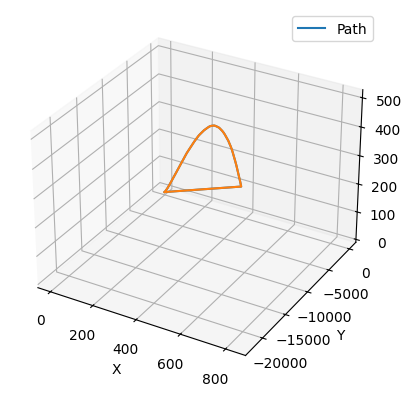

In [12]:
timestamps1 = timestamps[16000:80000:1]
ax = ax_values[16000:80000:1]
ay = ay_values[16000:80000:1]
az = az_values[16000:80000:1]
wx = wx_values[16000:80000:1]
wy = wy_values[16000:80000:1]
wz = wz_values[16000:80000:1]
print(len(ax))
print(len(ay))
print(len(timestamps1))

# samp_num, timestamps, wx_values, wy_values, wz_values, ax_values, ay_values, az_values,
# Initialize Mahony filter
# mahony = MahonyAHRS(sample_freq=600, kp=1.0, ki=0.0)
mahony = MahonyAHRS(sample_freq=40000, kp=1.0, ki=0.0)

# Initialize arrays to store Euler angles, velocities, and positions
euler_angles = np.zeros((len(timestamps), 3))
velocity = np.zeros((len(timestamps), 3))
position = np.zeros((len(timestamps), 3))

# Calculate time differences
dt = np.diff(timestamps, prepend=timestamps[0])
# Process IMU data with Mahony filter
euler_angles = np.zeros((len(timestamps1), 3))
for i in range(1, len(timestamps1)):
    gyroscope = np.array([wx[i], wy[i], wz[i]])
    accelerometer = np.array([ax[i], ay[i], az[i]])
    print(accelerometer, len(accelerometer))

    mahony.update(gyroscope, accelerometer)
    euler = R.from_quat(mahony.q).as_euler('xyz', degrees=True)
    euler_angles[i] = euler
    
    # Update velocity and position for each axis
    velocity[i] = velocity[i-1] + accelerometer * dt[i]
    position[i] = position[i-1] + velocity[i] * dt[i]

# accelerometer_data = np.zeros((len(timestamps1), 3))
print(velocity, len(velocity))
print("hey")
print(position, len(position))

# Plot the results
fig = plt.figure()
axyz = fig.add_subplot(111, projection='3d')

# Plot the 3D position
axyz.plot(position[:, 0], position[:, 1], position[:, 2], label='Path')
axyz.set_xlabel('X')
axyz.set_ylabel('Y')
axyz.set_zlabel('Z')
axyz.legend()

# Function to update the plot for animation
def update(num, position, line):
    line.set_data(position[:num, 0], position[:num, 1])
    line.set_3d_properties(position[:num, 2])
    return line,

line, = axyz.plot(position[:, 0], position[:, 1], position[:, 2], label='Path')

ani = FuncAnimation(fig, update, frames=len(timestamps), fargs=(position, line), interval=25, blit=False)

# Keep the animation object alive
plt.show()

In [13]:
import math

# Constants
GRAVITY = 9.81  # Acceleration due to gravity (m/s^2)
TWO_KI = 2.0 * 0.1  # Constant for integral gain
TWO_KP = 2.0 * 0.5  # Constant for proportional gain

class MahonyFilter:
    def __init__(self):
        self.q0 = 1.0
        self.q1 = 0.0
        self.q2 = 0.0
        self.q3 = 0.0

    def update_orientation(self, ax, ay, az, gx, gy, gz, dt):
        # Normalize accelerometer measurements
        norm = math.sqrt(ax * ax + ay * ay + az * az)
        ax /= norm
        ay /= norm
        az /= norm

        # Estimate gravity vector
        vx = 2.0 * (self.q1 * self.q3 - self.q0 * self.q2)
        vy = 2.0 * (self.q0 * self.q1 + self.q2 * self.q3)
        vz = self.q0 * self.q0 - self.q1 * self.q1 - self.q2 * self.q2 + self.q3 * self.q3

        # Error is the cross product between estimated and measured gravity vectors
        ex = ay * vz - az * vy
        ey = az * vx - ax * vz
        ez = ax * vy - ay * vx

        # Integrate the error with the integral gain
        integral_fb_x = ex * TWO_KI
        integral_fb_y = ey * TWO_KI
        integral_fb_z = ez * TWO_KI

        # Apply the proportional gain
        gx += TWO_KP * ex
        gy += TWO_KP * ey
        gz += TWO_KP * ez

        # Integrate the quaternion rate and normalize
        q0_dot = 0.5 * (-self.q1 * gx - self.q2 * gy - self.q3 * gz)
        q1_dot = 0.5 * (self.q0 * gx + self.q2 * gz - self.q3 * gy)
        q2_dot = 0.5 * (self.q0 * gy - self.q1 * gz + self.q3 * gx)
        q3_dot = 0.5 * (self.q0 * gz + self.q1 * gy - self.q2 * gx)

        self.q0 += q0_dot * dt
        self.q1 += q1_dot * dt
        self.q2 += q2_dot * dt
        self.q3 += q3_dot * dt

        # Normalize the quaternion
        norm_q = math.sqrt(self.q0 * self.q0 + self.q1 * self.q1 + self.q2 * self.q2 + self.q3 * self.q3)
        self.q0 /= norm_q
        self.q1 /= norm_q
        self.q2 /= norm_q
        self.q3 /= norm_q

class PositionEstimator:
    def __init__(self):
        self.x = 0.0
        self.y = 0.0
        self.z = 0.0
        self.vx = 0.0
        self.vy = 0.0
        self.vz = 0.0

    def update_position(self, ax, ay, az, dt, mahony_filter):
        # Rotate the accelerometer measurements to the world frame
        acc_world_x, acc_world_y, acc_world_z = self.rotate_acceleration_to_world_frame(
            ax, ay, az, mahony_filter.q0, mahony_filter.q1, mahony_filter.q2, mahony_filter.q3)

        # Integrate the linear acceleration to get velocity
        self.vx += acc_world_x * dt
        self.vy += acc_world_y * dt
        self.vz += acc_world_z * dt

        # Integrate the velocity to get position
        self.x += self.vx * dt
        self.y += self.vy * dt
        self.z += self.vz * dt

    @staticmethod
    def rotate_acceleration_to_world_frame(ax, ay, az, q0, q1, q2, q3):
        q0q0 = q0 * q0
        q1q1 = q1 * q1
        q2q2 = q2 * q2
        q3q3 = q3 * q3
        q0q1 = q0 * q1
        q0q2 = q0 * q2
        q0q3 = q0 * q3
        q1q2 = q1 * q2
        q1q3 = q1 * q3
        q2q3 = q2 * q3

        acc_world_x = (q0q0 + q1q1 - q2q2 - q3q3) * ax + 2.0 * (q1q2 - q0q3) * ay + 2.0 * (q1q3 + q0q2) * az
        acc_world_y = 2.0 * (q1q2 + q0q3) * ax + (q0q0 - q1q1 + q2q2 - q3q3) * ay + 2.0 * (q2q3 - q0q1) * az
        acc_world_z = 2.0 * (q1q3 - q0q2) * ax + 2.0 * (q2q3 + q0q1) * ay + (q0q0 - q1q1 - q2q2 + q3q3) * az

        return acc_world_x, acc_world_y, acc_world_z

    def get_position_history(self):
        return [self.x, self.y, self.z]
    
    
    mahony_filter = MahonyFilter()
pos_estimator = PositionEstimator()
dt = 0.01  # Assuming a 100 Hz sampling rate

position_history = []

# Read sensor measurements (ax, ay, az, gx, gy, gz)
# ...

mahony_filter.update_orientation(ax, ay, az, gx, gy, gz, dt)
pos_estimator.update_position(ax, ay, az, dt, mahony_filter)

# Store the current position in the position history
position_history.append(pos_estimator.get_position_history())
import matplotlib.pyplot as plt

# Assuming position_history is a list of lists, where each inner list represents [x, y, z]
x_coords = [point[0] for point in position_history]
y_coords = [point[1] for point in position_history]
z_coords = [point[2] for point in position_history]

fig = plt.figure()
ax = fig.add_subplot

NameError: name 'mahony_filter' is not defined

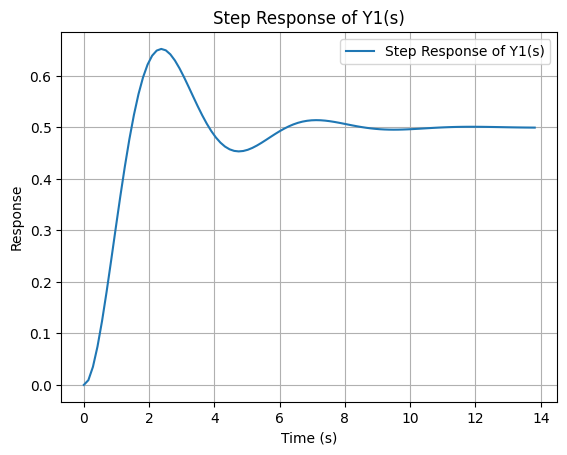

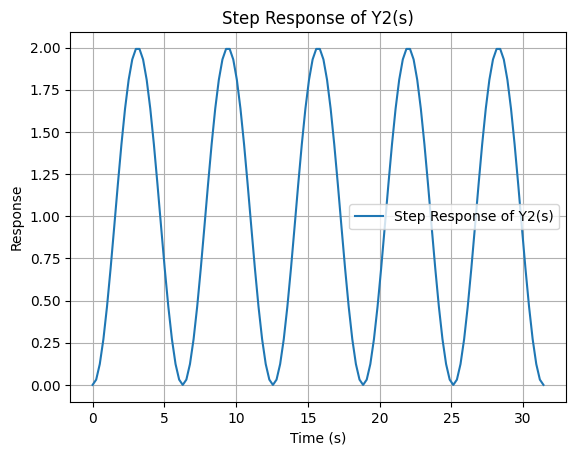

TypeError: unrecognized keywords: {'Plot': True}

<Figure size 640x480 with 0 Axes>